# The Changing Economics of Big Budget Films (2015–2024)

*Is the economic logic of big budget filmmaking breaking down? Why does it seem so many modern blockbusters are tanking in the box office?*

### Project Overview

Historically, large budgets tend to correlate with box office success, however, in the last decade that relationship appears to be weaker, with more high budget films underperforming.

This project works to analyze if production budget has become a less reliable predictor of financial success in the modern film industry. Using The Movie Database (TMDb) API data from 2015–2024, the analysis draws focus on profitability and return on investment (ROI) with particular attention to high budget films and genre specific risk. The project also acts as a personal case study and at its core will serve as a bounce off foundation for self learning Python as well as how to analyze and visualize data ☺︎

*To account for any structural disruption caused by the COVID-19 pandemic, the years 2020–2021 are analyzed separately from pre-COVID and post-COVID periods.*

**Environment & Dependencies**

This analysis was conducted in Python using Jupyter Notebook.  
Primary libraries include pandas, numpy, matplotlib, and requests.  
Data was collected via the TMDB API (v3).

# Asking Questions

Based on the dataset, we are interested to know:
* Q1: Has the relationship between budget and revenue weakened in the last decade?
* Q2: Are high budget films less efficient than mid budget films today?
* Q3: Has the rate of unprofitable high budget films increased over time?
* Q4: Do certain genres absorb budget risk better than others?
* Q5: Are modern successes driven by outliers rather than consistency?

***

# Data Wrangling #

## API ###

First, we will set up our API key.  

Source: <https://developers.themoviedb.org/3/getting-started/introduction>

### TMDB API key setup
*Ran into a lot of issues with TMDBs rate limiting/hard coding an the API key into the notebook, so instead opted to create a .csv file with the pulled dataset from TMDB. I have kept my original import function in here (API key redacted) for logging/learning purposes. The API will only need to be re-pulled in the event we need to recall new TMDB data.*

import os

os.environ["TMDB_API_KEY"] = "my api key"

## Preparing the Environment ##

Now that we have our API set up, we can prepare the environment and load and assess our dataset. We can also now clean and process the data to further analyze it. Here I built a helper function (tmdb_get) to standardize all GET requests to the TMDB API. The function automatically appends the API key, constructs the request URL, handles errors, and returns the response as a Python dictionary.

In [2]:
# Import libraries
import os
import time
import requests
import pandas as pd

# TMDB API setup (this is only needed for the optional data collection step which is null if using the .csv file)
API_KEY = os.getenv('TMDB_API_KEY')
BASE_URL = 'https://api.themoviedb.org/3'

# reuse connections + add lightweight retries for transient network issues
session = requests.Session()
try:
    from requests.adapters import HTTPAdapter
    from urllib3.util.retry import Retry
    retry = Retry(
        total=5,
        backoff_factor=1.0,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=['GET'],
    )
    session.mount('https://', HTTPAdapter(max_retries=retry))
except Exception:
    pass

def tmdb_get(path: str, params: dict | None = None) -> dict:
    """GET request helper for TMDB v3 API."""
    if not API_KEY:
        raise ValueError('TMDB_API_KEY is missing. Set it to run API collection.')
    if params is None:
        params = {}
    params = {**params, 'api_key': API_KEY}
    url = f"{BASE_URL}{path}"
    r = session.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()


## Step: Data loading (preferred)
Load the cached CSV if it exists so analysis runs without re-calling the TMDB API.

In [ ]:
from pathlib import Path

# try to locate a /data folder relative to the notebook location.
cwd = Path.cwd()
candidates = [cwd/'data', cwd.parent/'data', cwd.parent.parent/'data']
DATA_DIR = next((p for p in candidates if p.exists()), candidates[1])
DATA_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH = DATA_DIR / 'tmdb_movies_2015_2024_popularity_top.csv'

if DATA_PATH.exists():
    df_raw = pd.read_csv(DATA_PATH)
    df = df_raw.copy()
    print(f'Loaded cached dataset from {DATA_PATH} ->', df.shape)
else:
    print('No cached CSV found at:', DATA_PATH)
    print('Run the Data Collection step below once to create it.')


Here we are using TMDB’s /discover/movie endpoint. It scrolls through multiple result pages, sorted by popularity, and aggregates the results into a single list of movie records. We are also filtering out adult and video only content and adding a short delay between requests so we don't hit that rate limit.

In [60]:
# filter out adult movies and video content
def discover_movies_by_year(year: int, pages: int = 5) -> list[dict]:
    """Pull movies for a given year using /discover/movie.
    pages=5 means up to ~100 movies (20 per page)."""
    all_results = []
    for page in range(1, pages + 1):
        data = tmdb_get("/discover/movie", params={
            "primary_release_year": year,
            "sort_by": "popularity.desc",
            "include_adult": "false",
            "include_video": "false",
            "page": page
        })
        all_results.extend(data.get("results", []))
        time.sleep(0.2)  # be polite to the API
    return all_results

This function helps us fetch detailed metadata for a single movie using its TMDB movie ID. It retrieves the full movie record, including fields such as budget, revenue, runtime, and release information where available. A brief delay is included to respect TMDB’s rate limits once again.

In [59]:
def get_movie_details(movie_id: int) -> dict:
    """Pull full details for a movie. This includes budget & revenue when available."""
    data = tmdb_get(f"/movie/{movie_id}", params={"language": "en-US"})
    # delay
    time.sleep(0.2)
    return data

## Building the Raw Movie Dataset

This loop helps to construct the raw movie dataset by iterating through a defined range of release years and also working to discover popular movies for each year via the TMDB API. It deduplicates movies across years using a set of seen IDs, fetches full metadata for each unique title, and extracts key financial, popularity, and categorical fields into a structured list of records. The result is assembled into a pandas DataFrame (df_raw), forming the foundation for all downstream cleaning, analysis, and visualization.

In [5]:
from pathlib import Path

DATA_PATH = Path("../data/tmdb_movies_2015_2024_popularity_top.csv")

# Data Collection (run once)
# Set FORCE_REFRESH=True if you want to re-pull from the API even if the CSV exists.
FORCE_REFRESH = False

if DATA_PATH.exists() and not FORCE_REFRESH:
    print('Skipping API collection because cached CSV exists at:', DATA_PATH)
    print('Set FORCE_REFRESH=True to re-download.')
else:
    YEARS = list(range(2015, 2025))
    PAGES_PER_YEAR = 5 
    
    rows = []
    seen_ids = set()
    
    for y in YEARS:
        discovered = discover_movies_by_year(y, pages=PAGES_PER_YEAR)
        print(f"{y}: discovered {len(discovered)} movies")
        for m in discovered:
            mid = m.get("id")
            if not mid or mid in seen_ids:
                continue
            seen_ids.add(mid)
    
            details = get_movie_details(mid)
    
            rows.append({
                "id": details.get("id"),
                "title": details.get("title"),
                "release_date": details.get("release_date"),
                "release_year": int(details["release_date"][:4]) if details.get("release_date") else None,
                "runtime": details.get("runtime"),
                "budget": details.get("budget"),
                "revenue": details.get("revenue"),
                "vote_average": details.get("vote_average"),
                "vote_count": details.get("vote_count"),
                "popularity": details.get("popularity"),
                "genres": [g["name"] for g in details.get("genres", [])],
            })
    
    df_raw = pd.DataFrame(rows)
    df_raw.shape
    
    # Make df available for downstream analysis
    df = df_raw.copy()


Skipping API collection because cached CSV exists at: ../data/tmdb_movies_2015_2024_popularity_top.csv
Set FORCE_REFRESH=True to re-download.


## Assess Data ##

In this step we can now preview the dataset and get our basic information including budget, revenue, profit (as well as profitability), ROI, as well as Pre- or Post-COVID era.

In [57]:
# View first 3 rows of data
df.head(3)

,id,title,release_date,release_year,runtime,budget,revenue,vote_average,vote_count,popularity,genres,profit,roi,primary_genre,era,budget_tier,profitable
0,99861,Avengers: Age of Ultron,2015-04-22,2015,141,235000000,1405403694,7.271,23910,22.1651,"[Action, Adventure, Science Fiction]",1170403694,4.980441,Action,pre_covid,high,True
1,76341,Mad Max: Fury Road,2015-05-13,2015,121,150000000,378858340,7.628,23572,20.0886,"[Action, Adventure, Science Fiction]",228858340,1.525722,Action,pre_covid,high,True
2,216015,Fifty Shades of Grey,2015-02-11,2015,125,40000000,569651467,5.877,12187,18.3064,"[Drama, Romance, Thriller]",529651467,13.241287,Drama,pre_covid,mid,True


In [56]:
# Basic info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 497 entries, 0 to 986
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             497 non-null    int64  
 1   title          497 non-null    object 
 2   release_date   497 non-null    object 
 3   release_year   497 non-null    int64  
 4   runtime        497 non-null    int64  
 5   budget         497 non-null    int64  
 6   revenue        497 non-null    int64  
 7   vote_average   497 non-null    float64
 8   vote_count     497 non-null    int64  
 9   popularity     497 non-null    float64
 10  genres         497 non-null    object 
 11  profit         497 non-null    int64  
 12  roi            497 non-null    float64
 13  primary_genre  497 non-null    object 
 14  era            497 non-null    object 
 15  budget_tier    497 non-null    object 
 16  profitable     497 non-null    bool   
dtypes: bool(1), float64(3), int64(7), object(6)
memory usage: 6

## Data Collection

Movie data was collected using the TMDB API. For each year from 2015–2024, the top 100 most popular films were retrieved using the `/discover/movie` endpoint. Our detailed financial and metadata information was then fetched for each film using the `/movie/{id}` endpoint.

## Data Cleaning & Feature Engineering

To focus on our financially meaningful films, entries that have missing or zero budget or revenue values were removed. Several derived variables were created to support analysis, including profit, return on investment (ROI), budget tier classification, and era labels to distinguish pre-COVID, COVID, and post-COVID periods.

Duplicate entries were avoided during data collection by tracking unique movie IDs. Missing or invalid financial records were also excluded to focus on films with usable budget and revenue data. Only relevant fields were retained during ingestion, which reduced the need for extensive column pruning.

In [9]:
df = df_raw.copy()

# Basic cleaning
df = df.dropna(subset=["release_year", "budget", "revenue"])
df = df[(df["budget"] > 0) & (df["revenue"] > 0)]

# Feature engineering
df["profit"] = df["revenue"] - df["budget"]
df["roi"] = df["profit"] / df["budget"]

# Primary genre (first listed genre)
df["primary_genre"] = df["genres"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

df.shape

(497, 14)

In [10]:
def era_label(year: int) -> str:
    if 2015 <= year <= 2019:
        return "pre_covid"
    if 2020 <= year <= 2021:
        return "covid"
    if 2022 <= year <= 2024:
        return "post_covid"
    return "other"

df["era"] = df["release_year"].apply(era_label)

df["era"].value_counts()

era
pre_covid     259
post_covid    156
covid          82
Name: count, dtype: int64

# Exploratory Analysis

The following step saves the cleaned movie dataset to a CSV file for reuse outside the notebook. Exporting the data also allows the analysis to be reproducible, supports versioning, and makes it easier to load the dataset into other tools or notebooks without re-querying the entire TMDB API.

In [ ]:
# Save a cached copy for fast reloads (used by the Data Loading step)
if 'df' not in globals():
    raise NameError('df is not defined yet. Run data collection or load the CSV first.')

df.to_csv(DATA_PATH, index=False)
str(DATA_PATH)


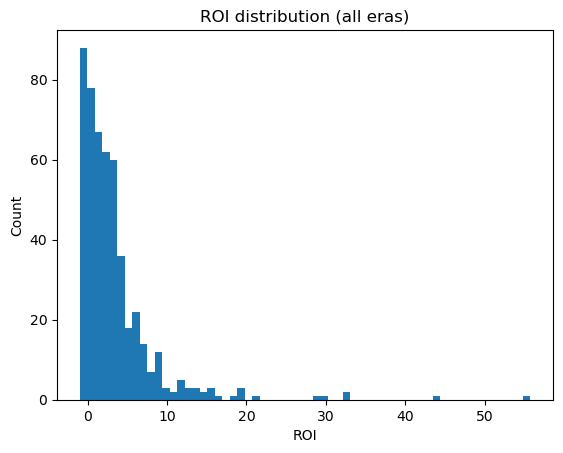

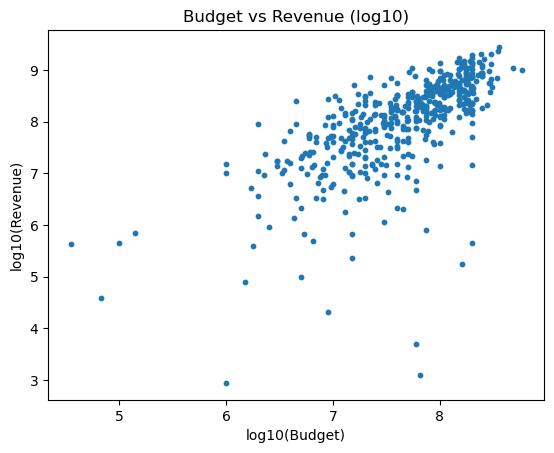

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.hist(df["roi"], bins=60)
plt.title("ROI distribution (all eras)")
plt.xlabel("ROI")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.scatter(np.log10(df["budget"]), np.log10(df["revenue"]), s=10)
plt.title("Budget vs Revenue (log10)")
plt.xlabel("log10(Budget)")
plt.ylabel("log10(Revenue)")
plt.show()

These plots provide an initial look at the financial characteristics of the dataset, and we can see just how skewed film ROI tends to be. Most movies tend to sit at low return levels, while a small number of breakout films generate disproportionately high ROI, creating a long right tail in the distribution. We can also see a positive correlation between revenue and budget, with a few outliers. 

I used this article to help understand how TMDB's data landscape works, what they collect, how much is user reported, etc. <https://ryan-anderson-ds.medium.com/what-makes-a-successful-film-predicting-a-films-revenue-and-user-rating-with-machine-learning-e2d1b42365e7>

In [13]:
df.shape
df["era"].value_counts()

era
pre_covid     259
post_covid    156
covid          82
Name: count, dtype: int64

Alright, now we have our structured, era aware dataset that shows:
* Pre-COVID (2015-2019): large enough to establish our baseline
* COVID (2020-2021): smaller and clearly abnormal data
* Post-COVID (2022-2024): big enough to test our "new norm"

In [14]:
df["budget"].describe()

count    4.970000e+02
mean     8.358667e+07
std      8.162364e+07
min      3.500000e+04
25%      1.830000e+07
50%      6.000000e+07
75%      1.290000e+08
max      5.839000e+08
Name: budget, dtype: float64

In [15]:
df["budget"].quantile([0.25, 0.5, 0.75, 0.9])

0.25     18300000.0
0.50     60000000.0
0.75    129000000.0
0.90    200000000.0
Name: budget, dtype: float64

So, our financially useable dataset is 497 movies (dramatic drop from the entire dataset since we filtered garbage entries)

### Key Budget Facts
* Median Budget: ~$60M
  
* 75th percentile: ~$129M

* 90th percentile: ~$200M

* Max: ~$584M (our true mega blockbuster)

In [67]:
# define our budget tiers
def budget_tier(budget):
    if budget < 18_300_000:
        return "low"
    elif budget <= 129_000_000:
        return "mid"
    else:
        return "high"

df["budget_tier"] = df["budget"].apply(budget_tier)
df["budget_tier"].value_counts()

budget_tier
mid     250
low     124
high    123
Name: count, dtype: int64

### Budget Tier Logic
* Low budget: < $18.3M

* Mid budget: $18.3M to $129M

* High budget: > $129M

In [68]:
# import Matplotlib’s plotting module, let's nickname it plt
import matplotlib.pyplot as plt
import numpy as np

With this nickname we can make a variety of charts like histograms, scatter plots, titles, axis labels, etc. We are also importing NumPy and aliasing it as np for fast math, arrays, etc. 

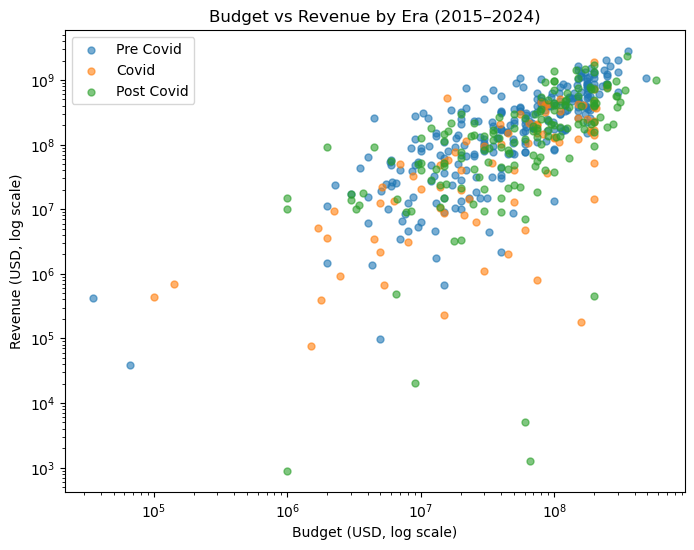

In [19]:
plt.figure(figsize=(8,6))

for era in ["pre_covid", "covid", "post_covid"]:
    subset = df[df["era"] == era]
    plt.scatter(
        subset["budget"],
        subset["revenue"],
        s=25,
        alpha=0.6,
        label=era.replace("_", " ").title()
    )

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Budget (USD, log scale)")
plt.ylabel("Revenue (USD, log scale)")
plt.title("Budget vs Revenue by Era (2015–2024)")
plt.legend()
plt.show()

**Interpretation:**  
So Pre-COVID films tend to show a relatively tight relationship between budget and revenue. Post-COVID releases exhibited substantially higher variance, in which we can infer that large budgets no longer guarantee predictable outcomes.

In [20]:
corr_by_year = (
    df
    .groupby("release_year")[["budget", "revenue"]]
    .corr()
    .iloc[0::2, -1]
    .reset_index()
)

corr_by_year.columns = ["release_year", "metric", "budget_revenue_corr"]
corr_by_year = corr_by_year[["release_year", "budget_revenue_corr"]]

corr_by_year

,release_year,budget_revenue_corr
0,2015,0.843411
1,2016,0.780965
2,2017,0.765928
3,2018,0.846824
4,2019,0.763831
5,2020,0.523108
6,2021,0.543537
7,2022,0.718533
8,2023,0.510930
9,2024,0.598969


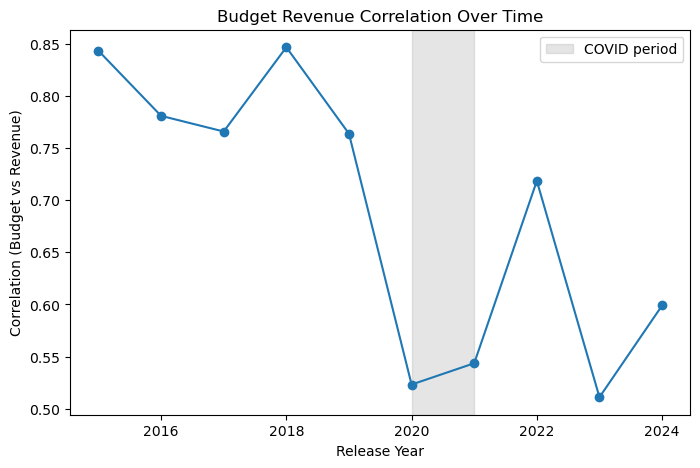

In [22]:
plt.figure(figsize=(8,5))

plt.plot(
    corr_by_year["release_year"],
    corr_by_year["budget_revenue_corr"],
    marker="o"
)

# Mark COVID years
plt.axvspan(2020, 2021, alpha=0.2, color="gray", label="COVID period")

plt.xlabel("Release Year")
plt.ylabel("Correlation (Budget vs Revenue)")
plt.title("Budget Revenue Correlation Over Time")
plt.legend()
plt.show()

**Observation:**  
While production budget remains positively correlated with revenue, the strength of this relationship becomes much more fragile after the COVID period, showing that reduced reliability and increased uncertainty of budget as a predictor of success.

*Post COVID budget revenue correlation shows sharp year to year swings rather than sustained recovery, indicating increased uncertainty in the financial performance of high budget films.*

In [23]:
df["profitable"] = df["profit"] > 0
df["profitable"].value_counts(normalize=True)

profitable
True     0.812877
False    0.187123
Name: proportion, dtype: float64

*A film is classified as unprofitable if its reported revenue is less than its production budget.*

In [24]:
high_budget = df[df["budget_tier"] == "high"]
high_budget.shape

(123, 17)

In [25]:
failure_rate = (
    high_budget
    .groupby("release_year")["profitable"]
    .apply(lambda x: (~x).mean())
    .reset_index()
)

failure_rate.columns = ["release_year", "failure_rate"]
failure_rate

,release_year,failure_rate
0,2015,0.000000
1,2016,0.000000
2,2017,0.055556
3,2018,0.000000
4,2019,0.000000
5,2020,0.600000
6,2021,0.312500
7,2022,0.090909
8,2023,0.142857
9,2024,0.214286


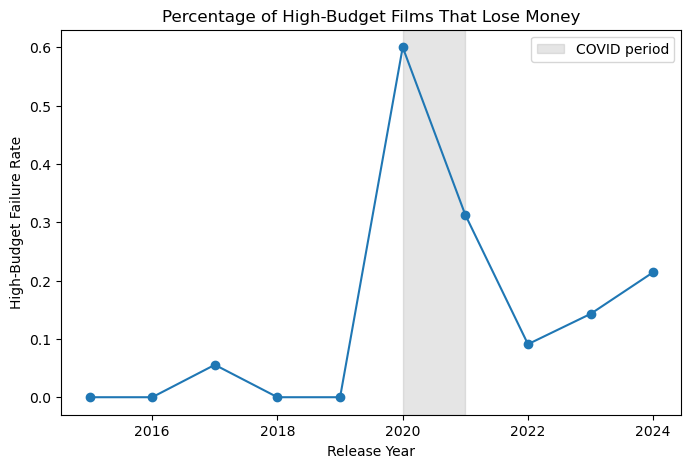

In [26]:
plt.figure(figsize=(8,5))

plt.plot(
    failure_rate["release_year"],
    failure_rate["failure_rate"],
    marker="o"
)

plt.axvspan(2020, 2021, alpha=0.2, color="gray", label="COVID period")

plt.xlabel("Release Year")
plt.ylabel("High-Budget Failure Rate")
plt.title("Percentage of High-Budget Films That Lose Money")
plt.legend()
plt.show()

**Observation:** 
While the 2020 theatrical shutdown represents an extreme outlier, the proportion of unprofitable high budget films remains elevated in the post-COVID period, suggesting a structural increase in downside risk rather than a temporary disruption.

## ROI Efficiency by Budget Tier

This analysis compares the efficiency of films across budget tiers using ROI, highlighting differences in typical performance and downside risk.

In [32]:
roi_by_tier = (
    df
    .groupby(["budget_tier", "era"])["roi"]
    .median()
    .reset_index()
)

roi_by_tier

,budget_tier,era,roi
0,high,covid,0.436632
1,high,post_covid,1.072675
2,high,pre_covid,3.083927
3,low,covid,1.129569
4,low,post_covid,2.767504
5,low,pre_covid,3.120000
6,mid,covid,0.910261
7,mid,post_covid,1.316285
8,mid,pre_covid,2.526365


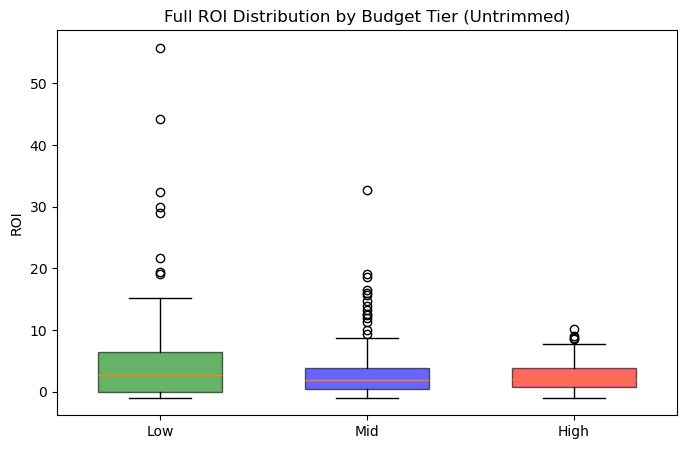

In [40]:
plt.figure(figsize=(8,5))

for tier, color in zip(
    ["low", "mid", "high"],
    ["green", "blue", "red"]
):
    subset = df[df["budget_tier"] == tier]
    plt.boxplot(
        subset["roi"],
        positions=[["low", "mid", "high"].index(tier)],
        widths=0.6,
        patch_artist=True,
        boxprops=dict(facecolor=color, alpha=0.6)
    )

plt.xticks([0,1,2], ["Low", "Mid", "High"])
plt.ylabel("ROI")
plt.title("Full ROI Distribution by Budget Tier (Untrimmed)")
plt.show()

### Handling Extreme ROI Outliers

The initial ROI distribution includes extreme outliers, particularly among lower budget films with unusually high returns.  
To better compare typical performance and downside risk across budget tiers, ROI values are trimmed to the range [-1, 5] in the following analysis.

In [36]:
df_roi_trimmed = df[df["roi"].between(-1, 5)]

print("Original size:", df.shape)
print("Trimmed size:", df_roi_trimmed.shape)

Original size: (497, 17)
Trimmed size: (403, 17)


In [37]:
df_roi_trimmed.groupby("budget_tier")["roi"].describe()

,count,mean,std,min,25%,50%,75%,max
budget_tier,,,,,,,,
high,101.0,1.635407,1.483076,-0.998887,0.411456,1.382353,2.631148,4.999080
low,91.0,1.392710,1.840185,-0.999119,-0.379425,1.037960,2.995829,4.787754
mid,211.0,1.588238,1.662248,-0.999980,0.221775,1.617582,3.023727,4.988901


<Figure size 800x500 with 0 Axes>

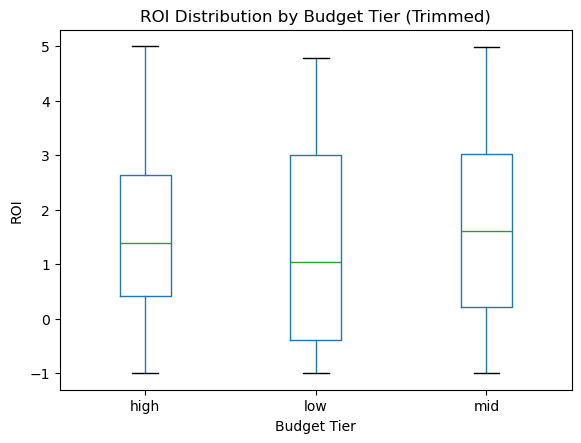

In [38]:
plt.figure(figsize=(8,5))

df_roi_trimmed.boxplot(
    column="roi",
    by="budget_tier",
    grid=False
)

plt.title("ROI Distribution by Budget Tier (Trimmed)")
plt.suptitle("")  # removes pandas auto-title
plt.xlabel("Budget Tier")
plt.ylabel("ROI")
plt.show()

**Observation:**
Low budget films exhibit higher median ROI, while high budget films show substantially greater downside risk, which shows that large scale productions are much less efficient despite their revenue potential.

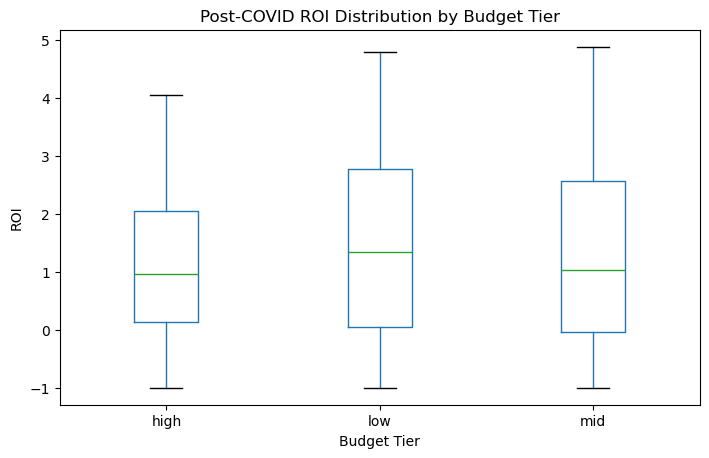

In [39]:
modern = df_roi_trimmed[df_roi_trimmed["era"] == "post_covid"]

modern.boxplot(
    column="roi",
    by="budget_tier",
    grid=False,
    figsize=(8,5)
)

plt.title("Post-COVID ROI Distribution by Budget Tier")
plt.suptitle("")
plt.xlabel("Budget Tier")
plt.ylabel("ROI")
plt.show()

**Observation:** In the post-COVID era, low budget films display the highest median ROI and the widest interquartile range, indicating both greater upside potential and higher variability in returns. Mid budget films show a slightly lower median ROI with a broad spread, which suggests moderate upside but continued financial uncertainty. High budget films have a comparable median ROI to mid budget films but have a more compressed distribution, showing that fewer extreme outcomes and more constrained returns relative to investment size. Overall, post-COVID ROI appears a lot less predictable across all tiers, with low budget films showing the strongest relative performance but also the greatest risk.

In [41]:
high_budget = df_roi_trimmed[df_roi_trimmed["budget_tier"] == "high"]

high_budget.shape

(101, 17)

In [42]:
genre_counts = (
    high_budget["primary_genre"]
    .value_counts()
)

genre_counts

primary_genre
Action             45
Science Fiction    14
Adventure          13
Animation           7
Fantasy             7
Family              6
Drama               3
Crime               2
Western             1
War                 1
Comedy              1
History             1
Name: count, dtype: int64

In [43]:
valid_genres = genre_counts[genre_counts >= 10].index.tolist()

high_budget_genre = high_budget[
    high_budget["primary_genre"].isin(valid_genres)
]

In [44]:
genre_roi = (
    high_budget_genre
    .groupby("primary_genre")["roi"]
    .median()
    .sort_values(ascending=False)
    .reset_index()
)

genre_roi

,primary_genre,roi
0,Action,1.382353
1,Science Fiction,1.374190
2,Adventure,1.192579


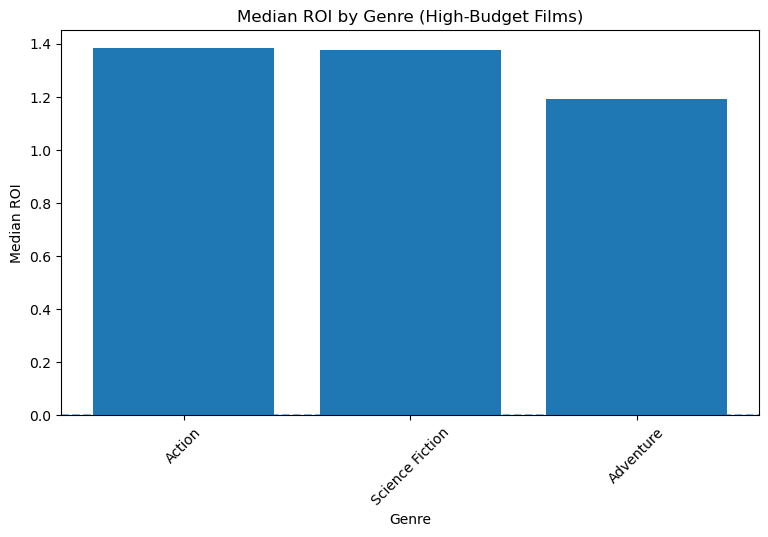

In [45]:
plt.figure(figsize=(9,5))

plt.bar(
    genre_roi["primary_genre"],
    genre_roi["roi"]
)

plt.axhline(0, linestyle="--", alpha=0.5)
plt.xlabel("Genre")
plt.ylabel("Median ROI")
plt.title("Median ROI by Genre (High-Budget Films)")
plt.xticks(rotation=45)
plt.show()

**Observation:** Among high budget films, genre plays a significant role in risk absorption. Certain genres maintain relatively stable ROI despite large production costs, while others exhibit high failure rates with limited upside, reinforcing the importance of genre selection in largeer scale film investments.

In [46]:
genre_failure = (
    high_budget_genre
    .groupby("primary_genre")["profitable"]
    .apply(lambda x: (~x).mean())
    .reset_index()
)

genre_failure.columns = ["primary_genre", "failure_rate"]

genre_failure

,primary_genre,failure_rate
0,Action,0.200000
1,Adventure,0.000000
2,Science Fiction,0.142857


In [47]:
genre_risk = pd.merge(
    genre_roi,
    genre_failure,
    on="primary_genre"
)

genre_risk

,primary_genre,roi,failure_rate
0,Action,1.382353,0.200000
1,Science Fiction,1.374190,0.142857
2,Adventure,1.192579,0.000000


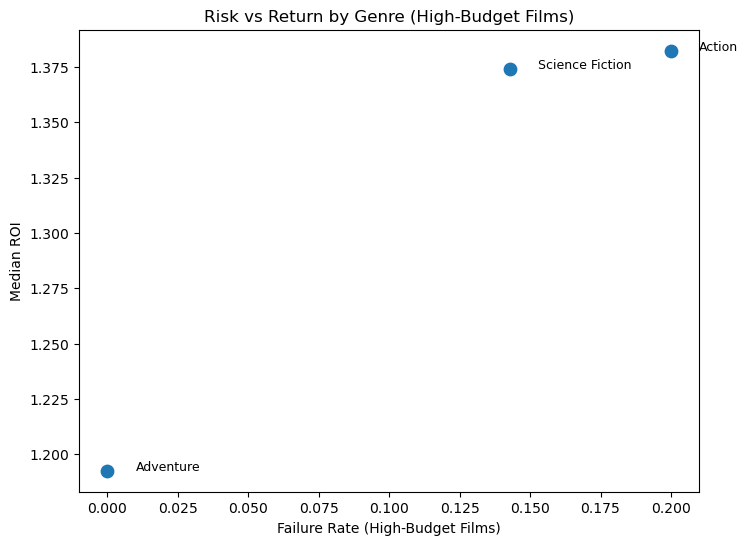

In [48]:
plt.figure(figsize=(8,6))

plt.scatter(
    genre_risk["failure_rate"],
    genre_risk["roi"],
    s=80
)

for _, row in genre_risk.iterrows():
    plt.text(
        row["failure_rate"] + 0.01,
        row["roi"],
        row["primary_genre"],
        fontsize=9
    )

plt.xlabel("Failure Rate (High-Budget Films)")
plt.ylabel("Median ROI")
plt.title("Risk vs Return by Genre (High-Budget Films)")
plt.show()

**Observation:** 

**Action / Adventure**
* Lower failure rates
* Moderate but reliable ROI
* Strong franchise and IP effects
* Audience expectations are clear

**Science Fiction**
* Some huge successes (very high upside)
* Also many expensive failures
* Heavy fixed costs (VFX, world building)
* ROI is high variance, not consistently high

*Science fiction films exhibit higher variance in outcomes, likely due to their reliance on costly visual effects and world building, which increases fixed costs and amplifies downside risk when audience reception is weak.*

# Conclusions #

To conclude, let's revisit our questions from earlier.

### Has the relationship between budget and revenue weakened in the last decade? ###
> Yes, we can see that the budget to revenue relationship was relatively stable pre-COVID, was dramatically weakened around 2020-2021, and then partially rebounded post-COVID. However, the rebound does not consistently return to pre-COVID levels, which might lead us to suggest that there is less reliability after the pandemic. In short, the budget still obviously plays a part, however, it no longer has as strong or consistent to signal revenue as it once was.

### Are high-budget films less efficient than mid-budget films today? ###
> Generally, yes, in terms of our ROI. The post COVID ROI by budget tier shows that high budget films do not outperform mid budgets on a median ROI basis. In fact, those mid budget films often times achieve similar or slightly higher ROI with less extreme downside risk. Obviously, high budget films require much higher revenue to break even, which tightends our ROI even when box office performance is strong. Thus, high budgets can amplify exposure however do not proportionally increase movie efficiency. 

### Has the rate of unprofitable high-budget films increased over time? ###
> Yes! Especially during or after the COVID period it is indicated that a larger share of high budget films fall below the beak even in the COVID and post-COVID eras compared to pre-COVID years. While it is still possible for blockbuster success, the downside risk for high budget productions has incresed a noticable amount, which is likely due to those shifting distribution models/audience behavior. 

### Do certain genres absorb budget risk better than others? ###
> Yup, and action and adventure shows the most resilience, while effects heavy genres tend to waver more. These genres usually maintain more stable returns across budget tiers, which is likely due to franchise effects and global appeal. Science fiction, while capable of that extreme upside, shows a greater downside dispersion which reflects high production costs and uneven audience reception. 

### Are modern successes driven by outliers rather than consistency? ###
> Yes, and increasingly so. Our ROI histograms and boxplots show very strong right skewness in recent years, with a small number of extreme successes driving overall averages. Median ROI remains modest across all budget tiers, with a few breakouts generating disproportionate returns. In short, modern film profitability appears much more dependent on rare hits rather than steady performance. 

## Limitations of the Dataset

* Not all films report budget and revenue figures to TMDB. Many entries have missing or zero valued budgets and revenues, particularly for smaller or international releases. This can bias ROI calculations toward films with more complete reporting and may underrepresent low visibility projects.
* Movies were collected using TMDB’s /discover/movie endpoint sorted by popularity, which favors higher visibility titles. As a result, the dataset does not represent a random or complete sample of all films released in each year, and findings are more reflective of widely discussed or marketed films rather than the full distribution of releases.
* Reported revenue reflects box office gross, not net profit. Marketing costs, distribution fees, and revenue splits with theaters are not included, meaning ROI is more of an approximation rather than being a true profitability measure.
* The COVID era introduced structural disruptions to film distribution, exhibition, and reporting. Reduced theater capacity, delayed releases, and streaming-first strategies complicate direct comparisons with pre and post-COVID years.Thus, observed changes during 2020–2021 may reflect industry disruption rather than underlying financial dynamics.

## Key Takeaways

- While production budget remains correlated with revenue, its predictive power has become increasingly weakened in the post-COVID period.
- High budget films exhibit higher failure rates and wider downside risk compared to mid and low budget productions.
- Low budget films achieve the highest median ROI, suggesting greater efficiency despite lower absolute returns.
- Among high budget films, genre plays a significant role in risk absorption: action and adventure genres appear more resilient, while science fiction exhibits a boom or bust profile with high variance in outcomes.

**Fun project! -Amanda ☺︎**